In [5]:
import numpy as np
#import matplotlib.pyplot as plt
import sys
sys.path.insert(1, "./../util/")
sys.path.insert(1, "./../model/")
from encoded_protein_dataset import EncodedProteinDataset#, collate_fn, get_embedding
from encoded_protein_dataset_new import get_embedding, EncodedProteinDataset_new, collate_fn_new
from pseudolikelihood import get_npll, get_npll_new, get_npll2
import torch, torchvision
from torch.nn.utils import clip_grad_norm_
from potts_decoder import PottsDecoder
from torch.utils.data import DataLoader, RandomSampler
from functools import partial
import biotite.structure
from biotite.structure.io import pdbx, pdb
from biotite.structure.residues import get_residues
from biotite.structure import filter_backbone
from biotite.structure import get_chains
from biotite.sequence import ProteinSequence
from typing import Sequence, Tuple, List
import scipy
from tqdm import tqdm
import pandas as pd
import csv
import time
from torch.utils.tensorboard import SummaryWriter

#import pytorch_warmup as warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR




import os
##TURIN HPC
#sys.path.insert(1, "/Data/silva/esm/")

## EUROPA
#sys.path.insert(1, "/home/lucasilva/esm/")

##Lucas computer
sys.path.insert(1, "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/esm")
import esm
#from esm.inverse_folding import util
import esm.pretrained as pretrained
from ioutils import read_fasta, read_encodings
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict


In [12]:
def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    '''
    
    # Run the command line tool and get the results.
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')

    # Use csv module to read and parse the result.
    reader = csv.reader(buf, delimiter=',')

    # Use a pandas table just for nice formatting.
    df = pd.DataFrame(reader)

    # Use the first row as the column headers.
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    # Display the formatted table.
    #display(df)

    return df

In [13]:
B=3
N=6
q=21
M=2

encodings = torch.randn((B, N, 512))
#encodings = 0.1 * torch.ones((B, N, 512))
msas = torch.randint(low=0, high=21, size=(B,M,N))

embeddings = get_embedding(q)
msas_embedded = embeddings(msas)
padding_mask = torch.zeros(size=(B, N),dtype=bool)
#padding_mask = torch.randint(low=0, high=2, size=(B,N), dtype=bool)
padding_mask_inv = (~padding_mask)

input_encoding_dim = 512
q=21
param_embed_dim = 512
n_param_heads = 4
d_model = 128
n_heads = 2
n_layers = 2
device = 0
eta = 1e-3
dropout = 0.0

device=1


decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)

model_path = 'D:/Data/InverseFolding/Intermediate_Models/parameters_seed_0_batch_size_4_nheads_2_d_128_nparheads_4_dropout_0.1_eta_0.001_update_3000000_noise_0.02'
decoder.load_state_dict(torch.load(model_path, map_location='cpu'))
decoder.eval();


In [14]:
param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
#fields

In [15]:
msas_embedded.shape

torch.Size([3, 2, 6, 21])

In [16]:
param_embeddings.shape

torch.Size([3, 4, 6, 21])

In [17]:
msas_embedded = msas_embedded.view(B,M,N,q)
param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
#param_embeddings = 1.0 * torch.ones(param_embeddings.shape)
npll2= get_npll2(msas_embedded, param_embeddings, fields, N, q)

Q = torch.einsum('bkuia, buhia->bkhia', 
                    param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1).sum(axis=-1)

## Later implement with einsum
## First multiplication: (B, N, q, 1, K) * (B, 1, 1, K, K) = (B, N, q, 1, K)
## Second multiplication: (B, N, Q, 1, K) * (B, N, Q, K, 1) = (B, N, Q, 1, 1)
## Flatten + Sums: (B, N, Q, 1, 1) --> (B, N, Q) ---> (B)
aux = torch.matmul(torch.matmul(param_embeddings.permute((0,2,3,1)).unsqueeze(-2), Q.unsqueeze(1).unsqueeze(1)),
                        param_embeddings.permute((0,2,3,1)).unsqueeze(-1)).flatten(2,4).sum(axis=-1).sum(axis=-1)
## Again we don't need any reegeneering for fields, penalty is wrong
penalty2 = eta*(aux - (param_embeddings**2).sum(axis=1).sum(axis=-1).sum(axis=-1) + torch.sum(fields**2))/B
npll2 = npll2 * padding_mask_inv.unsqueeze(1)
#loss2 = torch.sum(npll2)/(M*torch.sum(padding_mask_inv))


In [18]:
penalty2

tensor([-4.7525e-05, -1.0270e-04, -3.3078e-05], grad_fn=<DivBackward0>)

In [19]:
## New penalty implementation, which is much easier

Q2 = torch.einsum('bkuia, buhia->bkhia', 
                    param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)

penalty_new = eta*(torch.sum(torch.sum(Q2,axis=-1)**2) - torch.sum(Q2**2) + torch.sum(fields**2))/B

In [20]:
penalty_new

tensor(7.1347e-05, grad_fn=<DivBackward0>)

In [21]:
aux

tensor([0.0414, 0.0865, 0.0211], grad_fn=<SumBackward1>)

In [22]:
(param_embeddings**2).sum(axis=1).sum()

tensor(1.0412, grad_fn=<SumBackward0>)

In [23]:
msas_embedded.shape

torch.Size([3, 2, 6, 21])

In [24]:
couplings, fields = decoder(encodings, padding_mask)
#couplings, fields = decoder._get_params(param_embeddings.reshape(B,4,N,q), N, padding_mask)
fields_zero = torch.zeros(fields.shape)

npll = get_npll(msas_embedded.reshape(B,M,N*q), couplings, fields, N, q)
padding_mask_inv = (~padding_mask)

# multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
npll = npll * padding_mask_inv.unsqueeze(1)
penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B
#npll = npll * padding_mask_inv.unsqueeze(1)
#loss = torch.sum(npll) / (M * torch.sum(padding_mask_inv))

In [25]:
decoder.P.shape

torch.Size([4, 128, 128])

In [26]:
penalty - penalty_new

tensor(0.0002, grad_fn=<SubBackward0>)

In [27]:
npll

tensor([[[3.0768, 3.0074, 3.0138, 3.0193, 3.0852, 3.0382],
         [3.0508, 3.0664, 3.0141, 3.0615, 3.0573, 3.0913]],

        [[3.0679, 3.0469, 3.0676, 3.0537, 3.0669, 3.0142],
         [3.0711, 2.9423, 3.0888, 3.0356, 3.0901, 3.0915]],

        [[2.9672, 3.0382, 2.9788, 3.0473, 3.1011, 3.0270],
         [3.0552, 3.0466, 3.0649, 2.9964, 3.0657, 3.0218]]],
       grad_fn=<MulBackward0>)

In [ ]:
npll2

tensor([[[3.0310, 3.0544, 3.0617, 3.0262, 3.0674, 3.0377],
         [3.0331, 3.0161, 3.0642, 2.9928, 3.0638, 3.0494]],

        [[3.0599, 3.0818, 3.0402, 3.0463, 3.0558, 3.0441],
         [2.9705, 3.0692, 3.0361, 3.0679, 2.9936, 3.0498]],

        [[3.0473, 3.0396, 3.0709, 3.0523, 3.0688, 3.0024],
         [3.0891, 3.0557, 2.9659, 3.0878, 3.0186, 2.9629]]],
       grad_fn=<MulBackward0>)

In [ ]:
penalty

tensor(5.8326e-05, grad_fn=<DivBackward0>)

In [ ]:
penalty2

torch.Size([4])

## Let ut test another thing.

In [76]:
d_model = 512
n_param_heads = 24
N = 100
B=2

input = torch.randn((B, N, d_model))
module = torch.nn.modules.Linear(d_model, d_model*n_param_heads, bias = False)

output1 = module(input)

P = module.weight.reshape(n_param_heads, d_model, d_model)

output2 = (P.unsqueeze(0).unsqueeze(2) @ input.unsqueeze(1).unsqueeze(4)).squeeze()




In [17]:
output1.reshape(B, N, n_param_heads, d_model).transpose(1,2)[1,0,1:4,1:4]

tensor([[ 0.5280,  0.1547, -0.0513],
        [ 0.5419,  0.2455,  0.7675],
        [-0.3611, -0.0354,  0.1045]], grad_fn=<SliceBackward0>)

In [18]:
output2[1,0,1:4,1:4]

tensor([[ 0.5280,  0.1547, -0.0513],
        [ 0.5419,  0.2455,  0.7675],
        [-0.3611, -0.0354,  0.1045]], grad_fn=<SliceBackward0>)

## Yes they are the same

## Let us test the MLP module now

In [46]:
from torchvision.ops import MLP
from torch.nn.modules import LayerNorm

In [83]:
in_channels = 512
hidden_channels = [512]
norm_layer = LayerNorm
dropout=0.1
mlp_layer = MLP(in_channels=512, hidden_channels=hidden_channels, 
norm_layer=norm_layer, dropout=dropout)


In [84]:
mlp_layer.modules

<bound method Module.modules of MLP(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): Dropout(p=0.1, inplace=True)
)>

In [81]:
output = mlp_layer(input)

In [82]:
output.shape

torch.Size([2, 100, 512])

## From here I test

In [ ]:
B=4
N=512
q=21
M=16

encodings = torch.randn((B, N, 512))
#encodings = 0.1 * torch.ones((B, N, 512))
msas = torch.randint(low=0, high=21, size=(B,M,N))

embeddings = get_embedding(q)
#msas_embedded = embeddings(msas)
#padding_mask = torch.zeros(size=(B, N),dtype=bool)
padding_mask = torch.randint(low=0, high=2, size=(B,N), dtype=bool)
padding_mask_inv = (~padding_mask)

msas_test = torch.randint(low=0, high=21, size=(B,M,N))
encodings_test = torch.randn((B, N, 512))
padding_mask_test = torch.randint(low=0, high=2, size=(B,N), dtype=bool)
padding_mask_inv_test = (~padding_mask_test)


## TOY DATA FOR MEMORY BENCHMARK

In [ ]:
inputs_loader = [(msas, encodings, padding_mask)]
inputs_test_loader = [(msas_test, encodings_test, padding_mask_test)]

## REAL DATA

In [6]:
max_msas = 1000
msa_dir = "/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/msas/"
encoding_dir ="/media/luchinoprince/b1715ef3-045d-4bdf-b216-c211472fb5a2/Data/InverseFolding/structure_encodings/"


## OLD VERSION TOO MEMORY CONSUMING
#print("I am loading the train and test datasets")
#train_dataset = EncodedProteinDataset(os.path.join(msa_dir, 'train'), encoding_dir, max_msas=max_msas, noise=0.02)          ## Default value of noise used
#sequence_test_dataset = EncodedProteinDataset(os.path.join(msa_dir, 'test/sequence'), encoding_dir, noise=0.0, max_msas=max_msas)
#structure_test_dataset = EncodedProteinDataset(os.path.join(msa_dir, 'test/structure'), encoding_dir, noise=0.0, max_msas=max_msas)
#superfamily_test_dataset = EncodedProteinDataset(os.path.join(msa_dir, 'test/superfamily'), encoding_dir, noise=0.0, max_msas=max_msas)
#print(f"I have loaded the train and test datasets: seq:{len(sequence_test_dataset)}, str:{len(structure_test_dataset)}, super:{len(superfamily_test_dataset)}")


train_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'train'), encoding_dir, noise=0.02, max_msas=max_msas)          ## Default value of noise used
sequence_test_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'test/sequence'), encoding_dir, noise=0.0, max_msas=max_msas)
structure_test_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'test/structure'), encoding_dir, noise=0.0, max_msas=max_msas)
superfamily_test_dataset = EncodedProteinDataset_new(os.path.join(msa_dir, 'test/superfamily'), encoding_dir, noise=0.0, max_msas=max_msas)


/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/InverseFolding/train/./../util/encoded_protein_dataset_new.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))


In [7]:
print(f"I have loaded the train and test datasets: train:{len(train_dataset)}, seq:{len(sequence_test_dataset)}, struc:{len(structure_test_dataset)}, super:{len(superfamily_test_dataset)}")

I have loaded the train and test datasets: train:1000, seq:1000, struc:1000, super:1000


In [8]:
batch_structure_size = 20   ### I think with empty GPU we can hgo up to 10
perc_subset_test = 1.0     ## During the training, for every dataset available we select a random 10% of its samples. Now moved to 100% due to noise in evaluation metrics
batch_msa_size = 16
q = 21                      ##isn't always 21??
collate_fn = partial(collate_fn_new, q=q, batch_msa_size=batch_msa_size)

train_loader = DataLoader(train_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=True)#, num_workers=3)
sequence_test_loader = DataLoader(sequence_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(sequence_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(sequence_test_dataset)/10)))#, num_workers=3)

structure_test_loader = DataLoader(structure_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(structure_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(structure_test_dataset))))#, num_workers=3)

superfamily_test_loader = DataLoader(superfamily_test_dataset, batch_size=batch_structure_size, collate_fn=collate_fn, shuffle=False, 
sampler=RandomSampler(superfamily_test_dataset, replacement=True, num_samples=int(perc_subset_test*len(superfamily_test_dataset))))#, num_workers=3)

In [9]:
len(train_dataset)/batch_structure_size

50.0

With batch size equal to $32$ we do an epoch every roughly 700 update steps, let us check the evaluation metrics every $10$ epochs, hence roughly every $7k$ update steps on the full test dataset(not for the sequence train dataset which is huge). This should give clearer plots. 

In [10]:
decoder = None
embedding = None
torch.cuda.empty_cache()

seed = 82477
torch.random.manual_seed(seed)
np.random.seed(seed)



update_steps = 7000                                      ##Usual values are update steps=10^5, test_steps=10^2
test_steps = 700
bk_iter = False                                                  ## This tells us how ofter we save a model(default values is every ten-thousand updates)
#n_epochs = update_steps//(len(train_dataset)//batch_structure_size)   ## the other update steps will be used for "partial epochs", I want to save the last complet epoch
#print(f"With update_steps:{update_steps} we will do {n_epochs} full epochs")

input_encoding_dim = 512
param_embed_dim = 512
n_param_heads = 48
d_model = 512 ##old 512
n_heads = 8 ## old 8
n_layers = 6
## Check before running which is the GPU which is free the most and put it as the running device
device = 0        ## DON'T SET TO ONE OTHER THAN IN SPECIAL SPECIAL OCCASIONS, VERY NOISYYYYY!
dropout = 0.1

decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)
embedding = get_embedding(q)
embedding.to(device)

#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=update_steps)
#warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)




512
512


Embedding(22, 21)

In [6]:
#!nvidia-smi

In [11]:
def get_loss_new(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    param_embeddings, fields = decoder.forward_new(encodings, padding_mask)
    msas_embedded = embedding(msas)

    # get npll
    npll = get_npll2(msas_embedded, param_embeddings, fields, N, q)
    padding_mask_inv = (~padding_mask)
    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    
    Q = torch.einsum('bkuia, buhia->bkhia', 
                param_embeddings.unsqueeze(2), param_embeddings.unsqueeze(1)).sum(axis=-1)
    penalty = eta*(torch.sum(torch.sum(Q,axis=-1)**2) - torch.sum(Q**2) + torch.sum(fields**2))/B
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 

def get_loss(decoder, inputs, eta):
    """eta is the multiplicative term in front of the penalized negative pseudo-log-likelihood"""
    msas, encodings, padding_mask  = [input.to(device) for input in inputs]
    B, M, N = msas.shape
    #print(f"encodings' shape{encodings.shape}, padding mask:{padding_mask.shape}")
    couplings, fields = decoder(encodings, padding_mask)

    # embed and reshape to (B, M, N*q)
    msas_embedded = embedding(msas).view(B, M, -1)

    # get npll
    npll = get_npll(msas_embedded, couplings, fields, N, q)
    padding_mask_inv = (~padding_mask)

    # multiply with the padding mask to filter non-existing residues (this is probably not necessary)       
    npll = npll * padding_mask_inv.unsqueeze(1)
    penalty = eta*(torch.sum(couplings**2) + torch.sum(fields**2))/B

    # the padding mask does not contain the msa dimension so we need to multiply by M
    npll_mean = torch.sum(npll) / (M * torch.sum(padding_mask_inv))
    loss_penalty = npll_mean + penalty
    return loss_penalty, npll_mean.item() 
    #return loss_penalty

def get_loss_loader(decoder, loader, eta):

    decoder.eval()
    losses = 0
    iterator = 0
    with torch.no_grad():
        for inputs in loader:
            iterator+=1
            _, npll = get_loss_new(decoder, inputs, eta) 
            losses+=npll
    
    return losses/iterator

## Let us load the benchmark model that seem to have plateauded in the training.

In [ ]:
bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'
fname_par = 'model_04_01_2023.pt'
checkpoint = torch.load(os.path.join(bk_dir, fname_par))

In [ ]:
decoder = PottsDecoder(q, n_layers, d_model, input_encoding_dim, param_embed_dim, n_heads, n_param_heads, dropout=dropout)
decoder.to(device)

decoder.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
optimizer.param_groups[0]['lr'] = 1e-4 ##change the learning rate!

In [ ]:
check=0
for inputs in train_loader:
    #loss_penalty, train_batch_loss = get_loss_new(decoder, inputs, eta)  
    check+=1
    if check>2:
        break

In [22]:
train_loss = sequence_test_loss = structure_test_loss=superfamily_test_loss = 2.4
update_step=2

summary_writer = SummaryWriter()#log_dir=logdir)
layout = {
    "metrics": {
        "loss": ["Multiline", ["loss/train", "loss/sequence", "loss/structure", "loss/superfamily"]],}
}
summary_writer.add_custom_scalars(layout)
hyperparams = { 'lr':1e-4, 'eta':1e-4, 'batch_size':batch_structure_size, 'n_param_heads':n_param_heads, 'n_layers':n_layers, 
                'dropout':dropout, 'param_embed_dim':param_embed_dim, 'n_heads': n_heads}
for i in range(50):
    update_step=i
    summary_writer.add_scalar('loss/train', train_loss+i, update_step)
    summary_writer.add_scalar('loss/sequence', sequence_test_loss+i, update_step)
    summary_writer.add_scalar('loss/structure', structure_test_loss+i, update_step)
    summary_writer.add_scalar('loss/superfamily', superfamily_test_loss+i, update_step)

    save_metrics = {'loss/train': 100+i, 'loss/sequence': 50+i, 'loss/structure': 12+i, 'loss/superfamily': 14+i}
    summary_writer.add_hparams(hyperparams, save_metrics)






## Let us also save the hyperparameters
#with summary_writer as w:

#save_metrics = {'loss/train': 100, 'loss/sequence': 50, 'loss/structure': 12, 'loss/superfamily': 14}
#summary_writer.add_hparams(hyperparams, save_metrics)

summary_writer.close()



In [37]:
6.0%2

0.0

In [12]:
### Setting up TensorBoard ######
#tb_folder = 'dropout_'+ str(args.dropout) + 'noise_' + str(args.noise) +'_new'
#tb_folder = 'new_test'
#logdir = os.path.join('./runs', tb_folder)
#logdir = './runs'
#torch.autograd.set_detect_anomaly(True)
summary_writer = SummaryWriter()#log_dir=logdir)
layout = {
    "metrics": {
        "loss": ["Multiline", ["loss/train", "loss/sequence", "loss/structure", "loss/superfamily"]],}
}
summary_writer.add_custom_scalars(layout)

## Let us also save the hyperparameters
#with summary_writer as w:
hyperparams = {'lr':1e-4, 'eta':1e-4, 'batch_size':batch_structure_size, 'batch_msa_size':batch_msa_size, 'n_param_heads':n_param_heads, 'n_layers':n_layers, 
                'dropout':dropout, 'param_embed_dim':param_embed_dim, 'n_heads': n_heads}


optimizer = torch.optim.AdamW(decoder.parameters(), lr=1e-4)
#scheduler1 = ReduceLROnPlateau(optimizer, 'min', patience=100)
#scheduler2 = MultiStepLR(optimizer, milestones=[1000, 2000], gamma = 1/np.sqrt(5))
eta = 1e-4
start = time.time()
with tqdm(total = update_steps) as pbar: ##This is used to have the nice loading bar while training
    train_loss = 0
    update_step = 0
    max_gpu=0
    train_batch_losses = []
    epoch = 0.0
    while update_step < update_steps:
        for inputs in train_loader:
            decoder.train()

            loss_penalty, train_batch_loss = get_loss_new(decoder, inputs, eta)    ## get the current loss for the batch
            optimizer.zero_grad()                           ## set previous gradients to 0
            loss_penalty.backward()                         ## Get gradients
            #clip_grad_norm_(decoder.parameters(), max_norm=2.0, norm_type=2)
            loss_penalty.detach()
            optimizer.step()                                ## Do a step of GD
            update_step += 1                                ## Increase update step (the update steps will count also different batches within the same epoch)
            epoch = update_step / len(train_loader)
            
            train_batch_losses.append(train_batch_loss) ## Here we append the lossess in the different batches within the same epoch

            ## We chain two different schedulers, one for the initial stage, and one for the plateau
            #scheduler1.step(loss_penalty)
            #cheduler2.step()
            
            ## Better understand the difference between lr_scheduler and warm_scheduler.
            #with warmup_scheduler.dampening():
            #    lr_scheduler.step()
            
            ## We want to keep track of the test loss not at every batch, too costrly otherwise. Usually set to once every 100.
            #if ((update_step-1) % test_steps == 0) or (update_step == update_steps - 1):
            if (update_step  == 1) or (epoch % 10 == 0):
                #print("I am here")
                #train_loss = np.mean(train_batch_losses)#torch.mean(train_batch_losses)  ##fix this
                train_loss = np.mean(train_batch_losses)
                summary_writer.add_scalar('loss/train', train_loss, update_step)
                #del loss_penalty
                #del train_batch_losses
                #train_loss=1              
                #sequence_test_loss = get_loss_loader(decoder, inputs_test_loader, eta)
                sequence_test_loss = get_loss_loader(decoder, sequence_test_loader, eta)
                structure_test_loss = get_loss_loader(decoder, structure_test_loader, eta)
                superfamily_test_loss = get_loss_loader(decoder, superfamily_test_loader, eta)
                #gpu = int((check_gpu_mem().values[device, 1])[1:-4])
                #if gpu > max_gpu:
                #    max_gpu = gpu
                summary_writer.add_scalar('loss/sequence', sequence_test_loss, update_step)
                summary_writer.add_scalar('loss/structure', structure_test_loss, update_step)
                summary_writer.add_scalar('loss/superfamily', superfamily_test_loss, update_step)

                ## UNCOMMENT THIS!
                train_batch_losses = []

            ##This gives me problem, I had to change the if condition
            #pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f} train_batch: {train_batch_loss:.2f} train: {train_loss:.2f}, sequence: {sequence_test_loss:.2f}, max_gpu:{max_gpu}')#, GPU total memory: {check_gpu_mem().values[device, 0]}, GPU used: {check_gpu_mem().values[device, 1]}')
            pbar.set_description(f'update_step: {update_step}, epoch: {epoch:.2f}  train: {train_loss:.2f}, sequence: {sequence_test_loss:.2f}, structure: {structure_test_loss:.2f}, superfamily: {superfamily_test_loss:.2f}')
            pbar.update(1)
            
print(f"It took {time.time()-start} seconds")
save_metrics = {'loss/train': train_loss, 'loss/sequence': sequence_test_loss, 
'loss/structure': structure_test_loss, 'loss/superfamily': superfamily_test_loss}
summary_writer.add_hparams(hyperparams, save_metrics)
summary_writer.close()

  0%|          | 0/7000 [00:00<?, ?it/s]/home/luchinoprince/Dropbox/Old_OneDrive/Phd/Second_year/research/Feinauer/InverseFolding/train/./../util/encoded_protein_dataset_new.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encodings = torch.tensor(read_encodings(encoding_path, trim=False))
/home/luchinoprince/anaconda3/envs/IF/lib/python3.9/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._transformer_encoder_layer_fwd(
update_step: 251, epoch: 5.02  train: 11.32, sequence: 4.13, structure: 4.44, superfamily: 4.30:   4%|▎         | 251/7000 [00:42<19:11,  5.86it/s]


KeyboardInterrupt: 

In [ ]:
#decoder.P.bias

In [57]:
bk_dir= 'D:/Data/InverseFolding/Intermediate_Models/'
fname_par = 'model_17_01_2023.pt'

##Arguments of the model, could be inferred
args = {}
args['n_layers'] = n_layers
args['input_encoding_dim'] = input_encoding_dim
args['param_embed_dim'] = param_embed_dim
args['n_heads'] = n_heads
args['n_param_heads'] = n_param_heads
args['dropout'] = dropout



d = {}
d['epoch'] = epoch
d['update_step'] = update_step
d['batch_size'] = batch_structure_size
d['seed'] = seed
d['eta'] = eta
d['noise'] = 0.02
d['args'] = args
d['model_state_dict'] = decoder.state_dict()
d['optimizer_state_dict'] = optimizer.state_dict()

torch.save(d, os.path.join(bk_dir, fname_par))

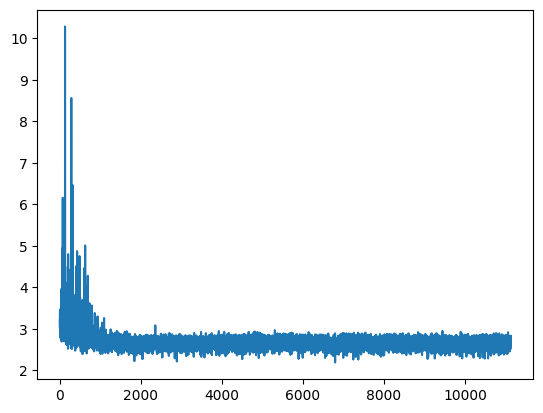

In [ ]:
plt.plot(train_batch_losses[100:])

In [ ]:
structure_test_loss

2.980251363345555

- MAX GPU old implementation: roughly $11$ Gbs, time to perform $1000$ update steps is $811$ seconds. 
- MAX GPU new implementation: roughly $2.3$ Gbs, time to perform $1000$ update steps is $70$ seconds.

In [ ]:
torch.cuda.empty_cache()